In the following code we will analyze a netflix dataset, where we will clean and observe some important characteristics and then try to create a model that predicts in which country netlix will post the movie from the name of the director and the length of the film. 

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, r2_score

In [2]:
# Read the first file into df and show the structure
df = pd.read_csv('netflix_titles.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [3]:
# Let's check how many nulls there are.
df.isnull().sum().sort_values(ascending=False)

director        2634
country          831
cast             825
date_added        10
rating             4
duration           3
show_id            0
type               0
title              0
release_year       0
listed_in          0
description        0
dtype: int64

In [4]:
# Changos! 30% of director data is null.
porc_nulos = df.isnull().sum() / len(df) * 100
porc_nulos.round(2).sort_values(ascending=False)

director        29.91
country          9.44
cast             9.37
date_added       0.11
rating           0.05
duration         0.03
show_id          0.00
type             0.00
title            0.00
release_year     0.00
listed_in        0.00
description      0.00
dtype: float64

In [5]:
# Bye bye 30% of the data, we have a few more than 8800 row so even without the 30% we still have a good number to work with, we also need to back up and clean up the gaps.
df_backup = df.copy() 
print('Data with null: ' + str(df.shape))
df=df.dropna()
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df['country'] = df['country'].str.strip().str.lower()
print('Data without null: ' + str(df.shape))

Data with null: (8807, 12)
Data without null: (5332, 12)


In [6]:
# I made another copy of dt. With 'df' the country will be exploded, which means that I only have one country for each cell because it is easier to train, and with df_test we can check the possible outcomes.
df_test = df.copy()
df = df.assign(country=df['country'].str.split(',')).explode('country').reset_index(drop=True)
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df[['show_id','director','country']].head(10)


,show_id,director,country
0,s8,Haile Gerima,united states
1,s8,Haile Gerima,ghana
2,s8,Haile Gerima,burkina faso
3,s8,Haile Gerima,united kingdom
4,s8,Haile Gerima,germany
5,s8,Haile Gerima,ethiopia
6,s9,Andy Devonshire,united kingdom
7,s10,Theodore Melfi,united states
8,s13,Christian Schwochow,germany
9,s13,Christian Schwochow,czech republic


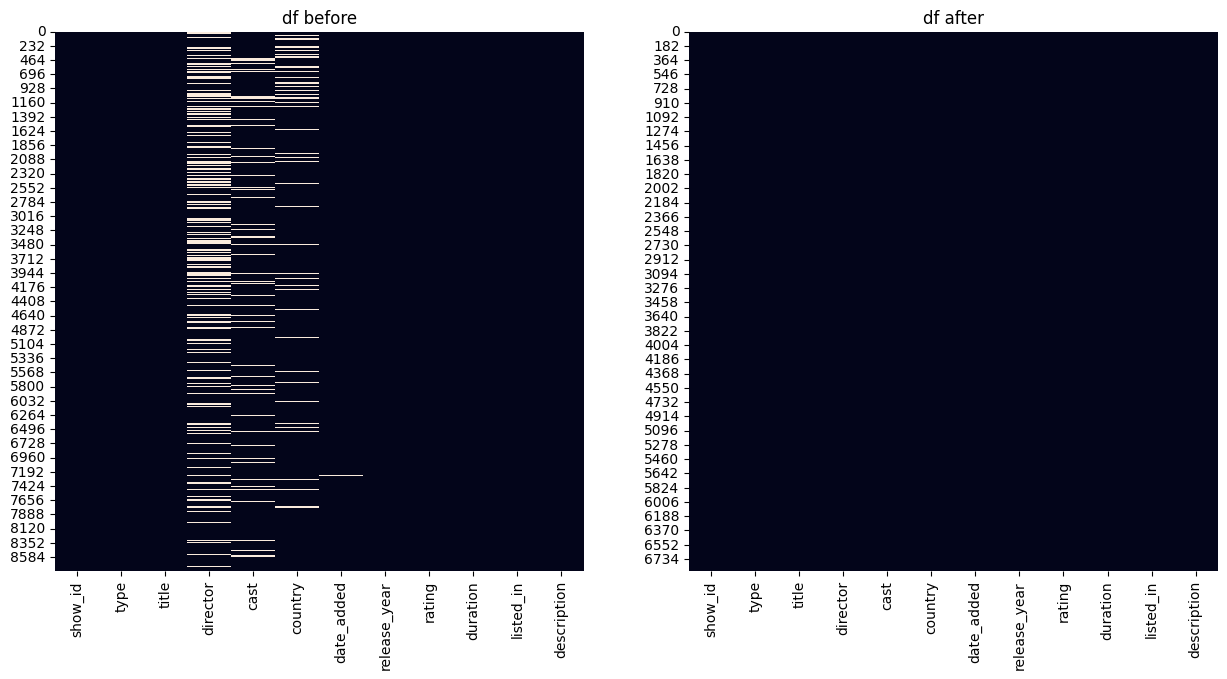

In [7]:
# Now we can see where the null values were and appreciate now our clean data.
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
sns.heatmap(df_backup.isnull(), cbar=False, ax=axs[0])
axs[0].set_title('df before')

sns.heatmap(df.isnull(), cbar=False, ax=axs[1])
axs[1].set_title('df after')

plt.show()

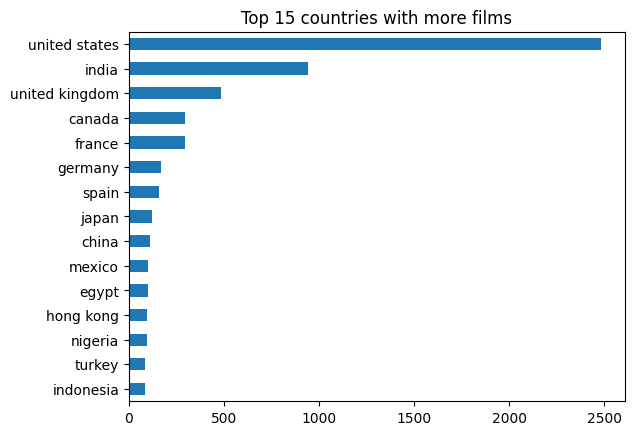

In [8]:
# What are the top 15 countries  with more films?
barras=df['country'].value_counts().sort_values(ascending=True).iloc[-15:].plot.barh()
plt.title ('Top 15 countries with more films')
plt.show()

The United States and India are the countries with the largest catalogs

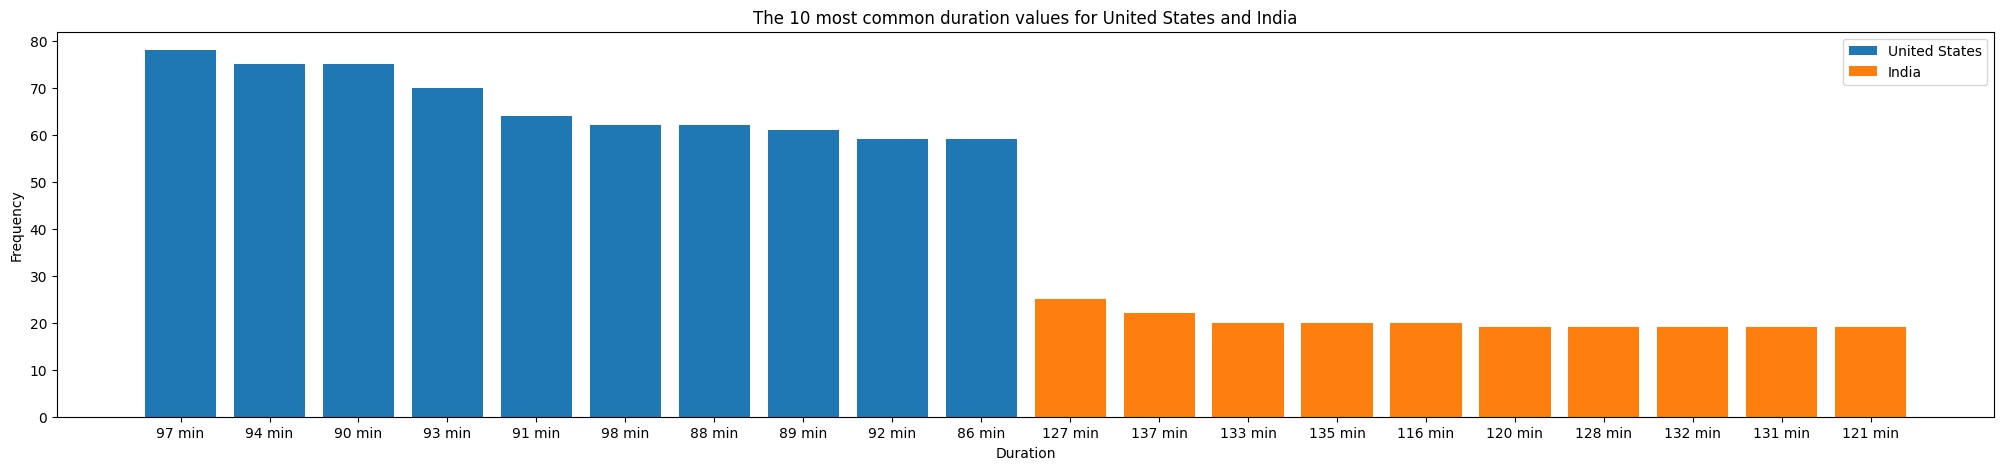

In [9]:
# Let's take a look at data from the United States and India.
usa_data = df.loc[df['country']=='united states', 'duration']
india_data = df.loc[df['country']=='india', 'duration']

# How long do movies usually last?
usa_duration_counts = usa_data.value_counts().head(10)
india_duration_counts = india_data.value_counts().head(10)

fig, ax = plt.subplots(figsize=(25, 5))
ax.bar(usa_duration_counts.index, usa_duration_counts.values, label='United States')
ax.bar(india_duration_counts.index, india_duration_counts.values, label='India')
ax.set_xlabel('Duration')
ax.set_ylabel('Frequency')
ax.set_title('The 10 most common duration values for United States and India')
ax.legend()
plt.show()

The length of the films is a relevant characteristic, since as we can see it is more common in the India for films to last longer.

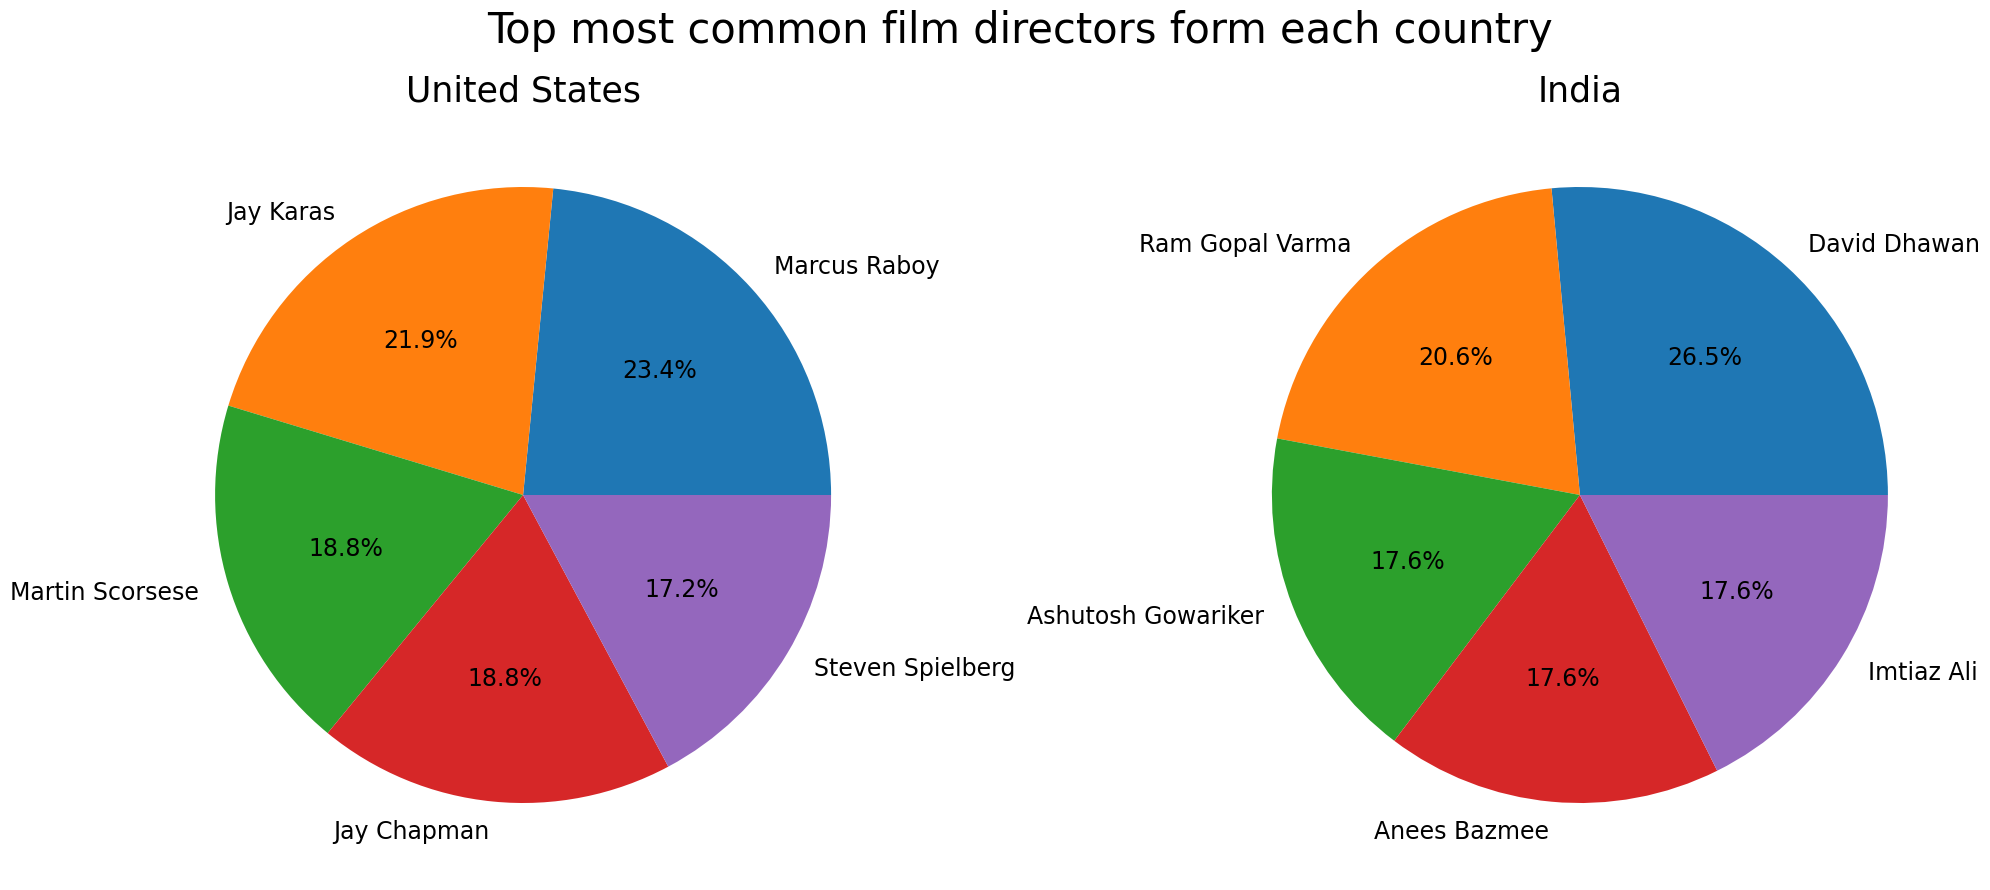

In [10]:
# Filter data for United States and India.
usa_data = df.loc[df['country']=='united states', 'director']
india_data = df.loc[df['country']=='india', 'director']

# Count the duration values for each country.
usa_director_counts = usa_data.value_counts().head(5)
india_director_counts = india_data.value_counts().head(5)

# Create subplots for United States and India.
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(25, 10))

# Plot pie chart for United States.
ax1.pie(usa_director_counts.values, labels=usa_director_counts.index, autopct='%1.1f%%', textprops={'fontsize':17})
ax1.set_title('United States',fontsize=25)

# Plot pie chart for India.
ax2.pie(india_director_counts.values, labels=india_director_counts.index, autopct='%1.1f%%',textprops={'fontsize':17})
ax2.set_title('India',fontsize=25)
fig.suptitle('Top most common film directors form each country', fontsize=30)

plt.show()

Another important feature is the directors of the movies, as we can see that the top 5 directors occupy more than 95% of the available catalog, in addition to the fact that these directors are relevant in one country but not in another.

In [11]:
# We encode to train the models easier.
cols_to_encode = ["country", "director", "duration"]

# And tadaaaa! let's print it out to take a peek.
for col in cols_to_encode:
    df[col+"_encode"] = LabelEncoder().fit_transform(df[col])
    print(df[[col, col+"_encode"]])

             country  country_encode
0      united states             103
1              ghana              34
2       burkina faso              14
3     united kingdom             102
4            germany              33
...              ...             ...
6877          jordan              49
6878   united states             103
6879   united states             103
6880   united states             103
6881           india              40

[6882 rows x 2 columns]
             director  director_encode
0        Haile Gerima             1309
1        Haile Gerima             1309
2        Haile Gerima             1309
3        Haile Gerima             1309
4        Haile Gerima             1309
...               ...              ...
6877  Majid Al Ansari             2201
6878    David Fincher              857
6879  Ruben Fleischer             3164
6880     Peter Hewitt             2817
6881      Mozez Singh             2537

[6882 rows x 2 columns]
     duration  duration_encode
0     1

In [12]:
# After separating the dataset, we now have numpy arrays named **X** containing the features, and **y** containing the labels.
X = df[['director_encode','duration_encode']].values
y = df['country_encode'].values
# Split data 70%-30% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))


Training Set: 4817 rows
Test Set: 2065 rows


In [13]:
#For each prediction, it uses the inverse transform of le_director 
#to get the director's name from the encoded value, and then checks 
#if the predicted country is in the list of countries associated 
#with the director in the df_test dataframe. If it is, it increments correcto.
def plot_accuracy(df_test, predictions,modelo):
    le_country = LabelEncoder().fit(df['country'])
    le_director = LabelEncoder().fit(df['director'])
    correct = 0
    for i in range(len(predictions)):
        director_prediction = le_director.inverse_transform([X_test[i][0]])[0]
        country_prediction = le_country.inverse_transform([predictions[i]])[0]
        for dir_val in df_test['director'].unique():
                    if director_prediction == dir_val:
                            row = df_test[df_test['director'] == dir_val]
                            if country_prediction in row['country'].iloc[0]:
                                    correct += 1
                                    break
    accuracy = correct / df_test['director'].nunique()
    
    # Create pie chart
    labels = ['Correct Predictions', 'Incorrect Predictions']
    sizes = [accuracy, 1 - accuracy]
    colors = ['#E50914', '#000000']

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
            startangle=90, textprops={'color': 'white', 'fontsize': 10})
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    # Add title
    plt.title('Select the right country\nModel: ' + modelo, fontsize=18, color='#000000')

    # Customize legend
    plt.legend(labels, loc="best", bbox_to_anchor=(0.85, 0.85))

    plt.show()

GradientBoostingRegressor()


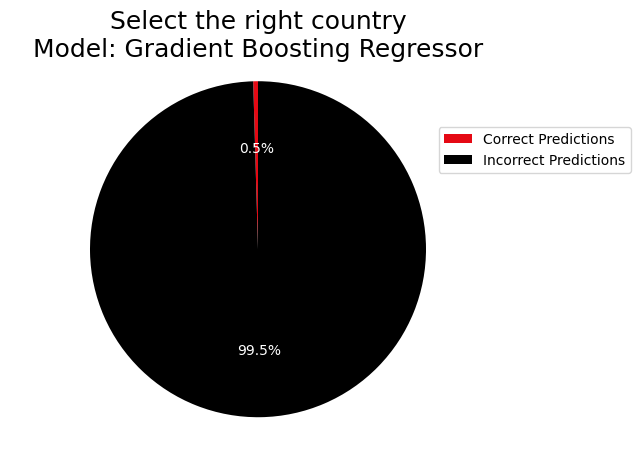

In [14]:
# Fit a lasso model on the training set and evalute it
model = GradientBoostingRegressor().fit(X_train, y_train)
print (model)
predictions = model.predict(X_test)
plot_accuracy(df_test,np.round(predictions).astype(int).tolist(), "Gradient Boosting Regressor")

Best parameter combination: {'learning_rate': 0.5, 'n_estimators': 20} 

GradientBoostingRegressor(learning_rate=0.5, n_estimators=20)


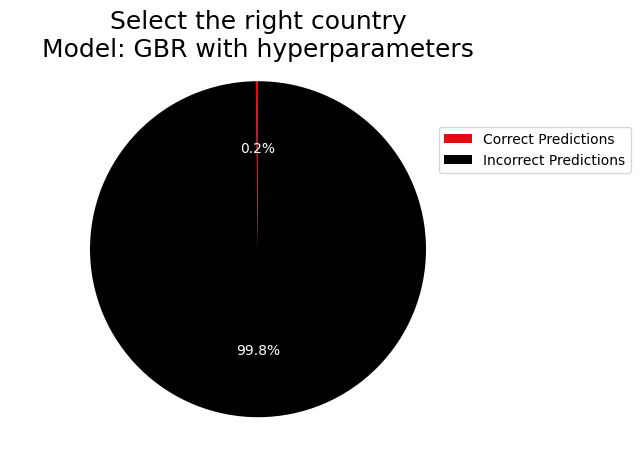

In [20]:
# Use a Gradient Boosting algorithm
alg = GradientBoostingRegressor()

# Try these hyperparameter values
params = {
 'learning_rate': [0.05, 0.5, 1],
 'n_estimators' : [20, 40, 60, 80]
 }

# Find the best hyperparameter combination to optimize the R2 metric
score = make_scorer(r2_score)
gridsearch = GridSearchCV(alg, params, scoring=score, cv=3, return_train_score=True)
gridsearch.fit(X_train, y_train)
print("Best parameter combination:", gridsearch.best_params_, "\n")

# Get the best model
model=gridsearch.best_estimator_
print (model)
# Evaluate the model using the test data
predictions = model.predict(X_test)
plot_accuracy(df_test,np.round(predictions).astype(int).tolist(), str("GBR with hyperparameters"))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  [0]),
                                                 ('cat',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder())]),
                                                  [])])),
                ('classifier', DecisionTreeClassifier())])


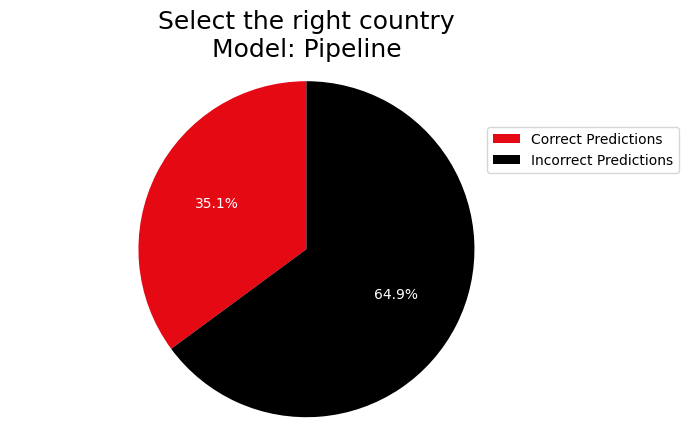

In [16]:
# Define preprocessing for numeric columns (scale them)
numeric_features = [0]
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                      ('scaler', StandardScaler())])

# Define preprocessing for categorical features (encode them)
categorical_features = []

categorical_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder())])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', DecisionTreeClassifier())])

# fit the pipeline to train a linear regression model on the training set
model = pipeline.fit(X_train, y_train)
print (model)
# Evaluate the model using the test data
predictions = model.predict(X_test)
plot_accuracy(df_test,np.round(predictions).astype(int).tolist(), "Pipeline")


In [17]:
# Save the model as a pickle file
filename = '.PredictCountryfromDirectorAndDuration.pkl'
joblib.dump(model, filename)

['.PredictCountryfromDirectorAndDuration.pkl']

In [18]:
#Let's check by ourselves the information, for this let's see how is coded the directors, countries and duration.
print(df[['title','director','director_encode','country','country_encode','duration','duration_encode']]
      .head(15))

                            title             director  director_encode  \
0                         Sankofa         Haile Gerima             1309   
1                         Sankofa         Haile Gerima             1309   
2                         Sankofa         Haile Gerima             1309   
3                         Sankofa         Haile Gerima             1309   
4                         Sankofa         Haile Gerima             1309   
5                         Sankofa         Haile Gerima             1309   
6   The Great British Baking Show      Andy Devonshire              256   
7                    The Starling       Theodore Melfi             3619   
8                    Je Suis Karl  Christian Schwochow              695   
9                    Je Suis Karl  Christian Schwochow              695   
10                          Jeans           S. Shankar             3183   
11                      Grown Ups         Dennis Dugan              925   
12                     Da

In [19]:
loaded_model = joblib.load(filename)

# An array of features based directo and duration
# Take the following examples
# No.5 Haile Gerima(1309) and 125min(27) Result excepet: United States(103), Ghana(34), Burkina Faso(14), United Kingdom(102), Germany(33) or Ethiopia(29)
# No.6 Andy Devonshire(256) and 9 Seasons(187) Result excepet: United Kingdom(102)
# [No.10 S. Shankar = 3183 and 166min = 72] Result excepet: India(40) 
# [No.14 Robert Luketic = 3089 and 106min = 7] Result excepet: India(40) or United States(103)
X_new = np.array([[1309, 27],
                  [256, 187],
                  [3183, 72],
                  [125, 7],])

le_country = LabelEncoder().fit(df['country'])
le_director = LabelEncoder().fit(df['director'])

# Use the model to predict rentals
results = loaded_model.predict(X_new)
print('In which country will Netflix show the film?')
for prediction, i in zip(results, range(len(X_new))):
    print(f'If the director is {le_director.inverse_transform([X_new[i][0]])[0]} the movie will show in {le_country.inverse_transform([int(np.round(prediction))])[0]}' )
    print(f'Code director {X_new[i][0]} -> {int(np.round(prediction))} Code country \n')


In which country will Netflix show the film?
If the director is Haile Gerima the movie will show in ghana
Code director 1309 -> 34 Code country 

If the director is Andy Devonshire the movie will show in united kingdom
Code director 256 -> 102 Code country 

If the director is S. Shankar the movie will show in japan
Code director 3183 -> 48 Code country 

If the director is Alex Burunova the movie will show in united states
Code director 125 -> 103 Code country 



As you can see the prediction about in which country a movie will be shown through Netflix with the data of the director's name and the length of the film is not reliable, to be honest it is more likely to be successful in saying that all movies will be shown in the United States (46% approximately) than using the third model (35.1%).

We also tried to test using RandomForestClassifier but we were having difficulties with the computational resources.

In the end I am satisfied, the result was better than I expected but there is always scope for improvement.